# Tutorial: Fairness-Aware Classification

[Fairlearn](https://fairlearn.org) is a Python toolkit for measuring and optimizing for fairness in machine learning. In this tutorial we will explore several techniques that can be used to advance fairness of a machine learning model.


---

**Learning Objectives**. After this tutorial you will be able to:
* apply techniques for fairness-aware classification in Python;
* examine strengths and limitations of different fairness-aware classification techniques;

--- 
**WARNING.** *Although the goal of this tutorial is to showcase fair-ml approaches, I would like to stress that **a data scientist's first actions should always include scrutinizing the need for machine learning, the machine learning task formulation, and data collection practices.** Especially in a sensitive application such as pre-trial risk assesment. Moreover, apart from fairness concerns, the accuracy of the models trained in this tutorial are only a bit better than random and likely not particularly useful in practice.*

---

### COMPAS: A Pre-Trial Risk Assessment Tool
COMPAS is a decision support tool used by courts in the United States to assess the likelihood of a defendant becoming a recidivist; i.e., relapses into criminal behavior. In particular, COMPAS risk scores are used in **pre-trial risk assessment**.

> #### What is pre-trial risk assessment in the US judicial system?
After somebody has been arrested, it will take some time before they go to trial. The primary goal of pre-trial risk assessment is to determine the likelihood that the defendant will re-appear in court at their trial. Based on the assessment, a judge decides whether a defendent will be detained or released while awaiting trial. In case of release, the judge also decides whether bail is set and for which amount. Bail usually takes the form of either a cash payment or a bond. If the defendant can't afford to pay the bail amount in cash - which can be as high as \$50,000 - they can contract a bondsmen. For a fee, typically around 10\% of the bail, the bondsmen will post the defendant's bail.
>
> If the defendant cannot afford bail nor a bail bond, they have to prepare for their trial while in jail. [This](https://eu.clarionledger.com/story/opinion/columnists/2020/05/28/cant-afford-bail-woman-describes-experience-mississippi-bail-fund-collective/5257295002/) [is](https://medium.com/dose/bail-is-so-expensive-it-forces-innocent-people-to-plead-guilty-72a3097a2ebe) [difficult](https://facctconference.org/2018/livestream_vh210.html). The time between getting arrested and a bail hearing can take days, weeks, months, or even years. In some cases, the decision is between pleading guilty and going home. Consequently, people who cannot afford bail are much more likely to plead guilty to a crime they did not commit. 
>
> If the judge's decision is a **false positive**, this has a big impact on the defendant's prospects. On the other extreme, **false negatives** could mean that dangerous individuals are released into society.
>
Proponents of risk assessment tools argue that they can lead to more efficient, less biased, and more consistent decisions compared to human decision makers. However, concerns have been raised that the scores can replicate historical inequalities.

#### Propublica's Analysis of COMPAS
In May 2016, investigative journalists of Propublica released a critical analysis of COMPAS. **Propublica's assessment: COMPAS wrongly labeled black defendants as future criminals at almost twice the rate as white defendants**, while white defendants were mislabeled as low risk more often than black defendants ([Propublica, 2016](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)). 

The analysis of COMPAS is likely one of the most well-known examples of algorithmic bias assessments. Within the machine learning research community, the incident sparked a renewed interest in fairness of machine learning models.

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay

# fairlearn
from fairlearn.metrics import (
    false_positive_rate,
    false_negative_rate,
    true_positive_rate,
    MetricFrame,
    equalized_odds_difference,
)
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

## Load and Pre-Process Data

You can download the data set collected by ProPublica [here](https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv). As in the previous tutorial, we pre-process the data similar to ProPublica and select all instances related to Caucasian and African-American defendants. As we intend to train a new classifier, we split the data into a training and test set.

In [2]:
# load data
df = pd.read_csv("compas-scores-two-years.csv")
# filter similar to propublica
df = df[
    (df["days_b_screening_arrest"] <= 30)
    & (df["days_b_screening_arrest"] >= -30)
    & (df["is_recid"] != -1)
    & (df["c_charge_degree"] != "O")
    & (df["score_text"] != "N/A")
]
# select two largest groups
df = df[(df["race"] == "African-American") | (df["race"] == "Caucasian")]
# select columns
df = df[
    [
        "sex",
        "age",
        "race",
        "priors_count",
        "juv_fel_count",
        "juv_misd_count",
        "juv_other_count",
        "two_year_recid",
    ]
]
# convert categorical variables to numerical to make suitable for ML model
df = pd.get_dummies(df, drop_first=True)
# define X and y
X = df.drop("two_year_recid", axis=1)
y = df["two_year_recid"]

# split the data in train-validation-test sets; use random_state for reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# inspect dataset
display(X_train.head())
# proportion of positives
print("proportion of positives (train): %.2f" % y_train.mean())

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,sex_Male,race_Caucasian
1054,53,2,0,0,0,1,0
731,36,4,0,0,0,0,0
5827,56,3,0,0,0,0,1
44,29,0,0,0,0,1,0
4475,27,2,0,0,0,1,1


proportion of positives (train): 0.47


The data now contains the following features:
* *age*. The defendant's age on the COMPAS screening date. 
* *priors_count*. The number of prior charges up to but not including the current offense.
* *juv_fel_count*. The number of prior charges for juvenile fellonies up to but not including the current offense.
* *juv_misd_count*. The number of prior charges for juvenile misdemeanors up to but not including the current offense.
* *juv_other_count*. The number of prior charges for other juvenile offenses up to but not including the current offense.
* *sex_Male*. The defendant's sex, measured as US census sex categories (either 1 for *Male* or 0 for *Female*).
* *race*. The defendant's race, measured as an adapted version of US census race categories (either 1 for *Caucasian* or 0 for *African-American*.

The proportion of positives in the data set is almost 0.5, which means that the dataset is balanced in terms of positives/negatives. This makes **accuracy** a (somewhat) suitable metric for measuring the overall predictive performance of our models.

### Equalized Odds
In this tutorial, we will attempt to train a **new classifier** for predicting recidivism with similar error rates across racial groups. In this way, we hope to avoid potential *quality-of-service harm*. 

> **Quality-of-service harm**: the algorithm makes more mistakes for some groups than for others. For example, in a hiring scenario, we may mistakingly reject strong female candidates more often than strong male candidates. 

The risk of quality-of-service harm is particularly prevalent if the relationship between the features and target variable is different across groups. The risk is further amplified if less data is available for some groups. We will measure potential quality-of-service harm using the fairness criterion *equalized odds*.

> **Equalized Odds** holds if, for all values of $y$ and $a$, $$P(\hat{Y} = y | A = a, Y = y) = P(\hat{Y} = y | A = a', Y = y)$$ where $\hat{Y}$ is the output of our model, $Y$ the observed outcome, and $A$ the set of sensitive characteristics.

In other words, the **false positive rate** and **false negative rate** should be equal across groups. As explained before, a false positive prediction in pre-trial risk assessment can have large consequences for the involved defendant, as they may have to await trial in jail. This may even result in the defendant pleading guilty to a crime they did not commit. On the other extreme, false negatives could mean that dangerous individuals are released into society.

In [3]:
def score(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    sensitive_features_train,
    sensitive_features_test,
    metrics={"accuracy": accuracy_score, "fpr": false_positive_rate, "fnr": false_negative_rate,},
):
    """
    Helper function to evaluate classifiers without too much repetition of code.
    """

    # training set
    mf_train = MetricFrame(
        metrics=metrics,
        y_true=y_train,
        y_pred=y_train_pred,
        sensitive_features=sensitive_features_train,
    )

    # test set
    mf_test = MetricFrame(
        metrics=metrics,
        y_true=y_test,
        y_pred=y_test_pred,
        sensitive_features=sensitive_features_test,
    )

    # display results
    display(
        pd.concat(
            [mf_train.by_group, mf_test.by_group], keys=["train", "test"]
        ).unstack(level=0)
    )

    # compute metrics
    print(
        "equalized odds (test): %.2f"
        % equalized_odds_difference(
            y_true=y_test,
            y_pred=y_test_pred,
            sensitive_features=X_test["race_Caucasian"],
        )
    )
    print("accuracy (test): %.2f" % accuracy_score(y_true=y_test, y_pred=y_test_pred))
    return

## Classification without Fairness Constraints

First, let's train a simple logistic regression classifier on the data and see how it performs.

**NOTE**. *If we were building a model to be put in production, we would encourage you to use a separate validation and test set. However, for the sake of simplicity, we only consider train and test set in this tutorial.*

### *Exercise*: train a `LogisticRegression` model on the data without fairness constraints

In [4]:
# TODO train simple logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# score
score(
    y_train,
    lr.predict(X_train),
    y_test,
    lr.predict(X_test),
    X_train["race_Caucasian"],
    X_test["race_Caucasian"],
)

accuracy                 fpr                fnr          
                   train      test     train     test     train      test
race_Caucasian                                                           
0               0.688547  0.682195  0.313462  0.28903  0.309666  0.345528
1               0.672727  0.674757  0.128035    0.104  0.639033  0.666667

equalized odds (test): 0.32
accuracy (test): 0.68


The test set accuracy of our classifier is approximately the same for African-Americans (0.69) and Caucasians (0.67). However, the FNR and FPR differ substantially, indicating that African-Americans are more often falsely predicted to recidivise, whereas Caucasians are more often falsely predicted to *not* recidivise. This disparity is reflected in the computed equalized odds difference (0.32).

> #### Intermezzo: Equalized Odds and Construct Validity
> In what scenarios should we use equalized odds as a fairness metric? Equalized odds quantifies the understanding of fairness that we should not make more mistakes for some groups than for other groups. Importantly, **equalized odds implicitly assumes that the target variable is a good representation of what we are actually interested in**: error rates are only meaningful if the ground-truth target variable is an unbiased measurement of the thing we are trying to predict.
>
> **Construct validity** is a concept from the social sciences that refers to *the extent to which a measurement actually measures the phenomenon we are trying to measure*. In the context of fairness, [a lack of construct validity in the target variable can be a source of downstream model unfairness](https://arxiv.org/abs/1912.05511).
> * [Healthcare costs can be a biased measurement of healthcare needs](https://science.sciencemag.org/content/366/6464/447.abstract), as costs may reflect patients' economic circumstances rather than their health
> * Historical hiring decisions are not necessarily equivalent to historical employee quality, due to systemic and/or (unconscious) social biases in the hiring process.
> * Observed fraud is only a subsample of actual fraud. If potential cases of fraud are not selected randomly, there is a risk of selection bias. If the selection biass is associated with sensitive group membership, some groups may be overscrutinized causing the observed fraud rate to be inflated.

Although we use equalized odds as a fairness constraint, we would like to acknowledge that **due to biased policing practices, re-arrests is likely a biased measurement of recidivism.**

## Fairness-Aware Machine Learning
There exist several technical approaches to explicitly incorporate fairness constraints in a machine learning model. We can roughly distinguish three types of approaches:
* **Pre-processing** algorithms adjust training data directly to mitigate downstream model unfairness. 
* **Constrained learning** approaches incorporate fairness constraints into the machine learning process, either by directly incorporating a constraint in the loss function or by learning an ensemble of predictors.
* **Post-processing** techniques make adjustments to existing machine learning models to satisfy fairness constraints, either by adjusting the parameters of a trained model directly or by post-processing the predictions of the model.

## Manually Post-Processing the Decision Threshold
In our previous model, we have simply applied the default decision threshold of 0.5 for both African-Americans and Caucasians. One way to account for differences in FPR and FNR is to **choose a separate threshold for each sensitive group**. Note that this implies that **different groups are held to a different standard**.

We will now choose a new decision threshold for African-Americans to ensure that the FPR of African-Americans is equal to the FPR of Caucasians. In our previous model, the FPR in the training set is approximately 0.13 for Caucasians. We use this as our target FPR for African-American defendants.

In [5]:
# make scoring predictions
y_train_score_lr = pd.Series(lr.predict_proba(X_train)[:, 1], index=X_train.index)
y_test_score_lr = pd.Series(lr.predict_proba(X_test)[:, 1], index=X_test.index)

# get indices for grouping
idx_AA_train = X_train[X_train["race_Caucasian"] == 0].index

# get new thresholds based on ROC curve for AA
fpr_AA_train, tpr_AA_train, thresholds_AA_train = roc_curve(
    y_true=y_train[idx_AA_train], y_score=y_train_score_lr[idx_AA_train]
)
new_thr = thresholds_AA_train[(np.abs(fpr_AA_train - 0.13)).argmin()]

print("New decision threshold for African-Americans: %.2f" % new_thr)

New decision threshold for African-Americans: 0.62


Based on the training data, we have computed that a decision threshold of 0.62 would lead to a FPR of approximately 0.13.

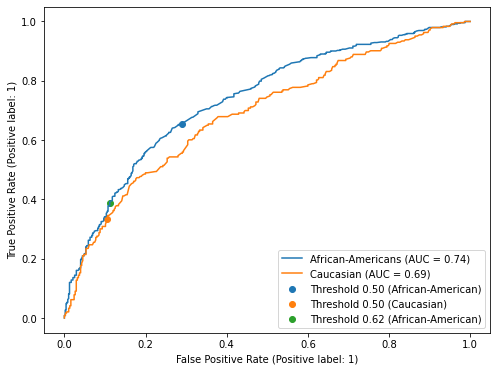

In [7]:
# get remaining indices for grouping
idx_AA_test = X_test[X_test["race_Caucasian"] == 0].index
idx_C_test = X_test[X_test["race_Caucasian"] == 1].index
idx_C_train = X_train[X_train["race_Caucasian"] == 1].index

# plot ROC curves
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

RocCurveDisplay.from_estimator(
    lr,
    X_test.loc[idx_AA_test, :],
    y_test.loc[idx_AA_test],
    name="African-Americans",
    ax=ax,
)

RocCurveDisplay.from_estimator(
    lr,
    X_test.loc[idx_C_test, :],
    y_test.loc[idx_C_test],
    name="Caucasian",
    ax=ax,
)

# add thresholds
plt.scatter(
    false_positive_rate(
        y_true=y_test[idx_AA_test], y_pred=y_test_score_lr[idx_AA_test] >= 0.5
    ),
    true_positive_rate(
        y_true=y_test[idx_AA_test], y_pred=y_test_score_lr[idx_AA_test] >= 0.5
    ),
    label="Threshold 0.50 (African-American)",
)
plt.scatter(
    false_positive_rate(
        y_true=y_test[idx_C_test], y_pred=y_test_score_lr[idx_C_test] >= 0.5
    ),
    true_positive_rate(
        y_true=y_test[idx_C_test], y_pred=y_test_score_lr[idx_C_test] >= 0.5
    ),
    label="Threshold 0.50 (Caucasian)",
)

plt.scatter(
    false_positive_rate(
        y_true=y_test[idx_AA_test], y_pred=y_test_score_lr[idx_AA_test] >= new_thr
    ),
    true_positive_rate(
        y_true=y_test[idx_AA_test], y_pred=y_test_score_lr[idx_AA_test] >= new_thr
    ),
    label="Threshold %.2f (African-American)" % new_thr,
)

plt.legend(loc="lower right")
plt.show()

This plot visualizes the results of our manual selection approach on the test data. We have plotted the ROC curve for each racial group separately. The original decision threshold of 0.5 resulted in higher TPR and FPR for African-Americans. By choosing a different threshold for this group, we end up on a point on the ROC curve that is much closer to the FPR and TPR of Caucasians.

Now let's evaluate the performance of the new decision threshold.

In [8]:
# make new predictions at two separate decision thresholds
y_train_pred_lr_m = pd.concat(
    [y_train_score_lr[idx_AA_train] >= new_thr, y_train_score_lr[idx_C_train] >= 0.5]
).reindex(X_train.index)
y_test_pred_lr_m = pd.concat(
    [y_test_score_lr[idx_AA_test] >= new_thr, y_test_score_lr[idx_C_test] >= 0.5]
).reindex(X_test.index)

# score
score(
    y_train,
    y_train_pred_lr_m,
    y_test,
    y_test_pred_lr_m,
    X_train["race_Caucasian"],
    X_test["race_Caucasian"],
)

accuracy                 fpr                 fnr          
                   train      test     train      test     train      test
race_Caucasian                                                            
0               0.622454  0.632505  0.130769  0.111814  0.597092  0.613821
1               0.672727  0.674757  0.128035     0.104  0.639033  0.666667

equalized odds (test): 0.05
accuracy (test): 0.65


As can be seen from this table, we have been able to substantially reduce equalized odds difference (decreased from 0.32 to 0.05), with similar overall accuracy (decreased from 0.68 to 0.65).

## Post-Processing Using `ThresholdOptimizer`
In addition to manual optimization, it is also possible to automatically determine group-specific decision thresholds. The class `fairlearn.postprocessing.ThresholdOptimizer` is based on the algorithm introduced by [Hardt. et al (2016)](https://papers.nips.cc/paper/2016/hash/9d2682367c3935defcb1f9e247a97c0d-Abstract.html). 

> #### Group-Specific Randomized Thresholds
> Equalized odds requires us to set the false positive rate and true positive rate equal across groups. Through group-specific decision thresholds, we can take any point on the group-specific ROC curve, which increases allows us to get a more similar FPR and FNR for both groups. However, group-specific thresholds still limit us to the (FPR, TPR) combinations that lie on the intersection of the group-specific ROC curves. In some cases, the group-specific ROC curves may not intersect or represent a poor trade-off between false positives and false negatives. 
>
> To further increase the solution space, the `ThresholdOptimizer` allows the group-specific decision thresholds to be **randomized**: we randomly pick between two distinct thresholds.
>
> <img src="randomizedthreshold.pdf" alt="a randomized decision threshold me" width="300"/>
>
>  The probability $p_a$ with which we choose one threshold over the other determines which (fpr,tpr) combination in the ROC space we end up with. How this works is the easiest to understand through a visualization. In the plot below, the solid curve represents the group-specific ROC curve of the group that is best-off. By randomizing between the two thresholds, we can achieve any (FPR,TPR) combination on the line between the two thresholds.
> 
> <img src="roccurve.pdf" alt="randomization allows us to achieve any fpr/tpr combination  under the group-specific ROC-curve." width="300"/>
>
> By carefully selecting the two decision thresholds and probability $p_a$, we can end up with a combination that is also on the group-specific ROC-curve of the worst-off group, satisfying equalized odds. The point on the ROC curve at which randomization is aimed, is optimized such that the disparity is the smallest, while predictive performance is the highest.
>
> Note that using this algorithm has the following implications:
> * The predictive performance for each group is decreased until it is equal to that of the worst-off group.
> * Due to randomization, two individuals with the exact same characteristics may receive a different classification.


The `ThresholdOptimizer` class has the following parameters: 
* `estimator`: the (fitted) classifier
* `constraints` : the fairness constraint for which we want to optimize, we can choose between `'demographic_parity'`, `'equalized odds'`, `'false_positive_rate_parity'` `'false_negative_rate_parity'`, `'true_positive_parity'` and `'true_negative_parity'`.
* `objective` : the predictive performance objective under which threshold optimization is performed. Not all objectives are allowed for all types of constraints. Possible inputs are: `'accuracy_score'`, `'balanced_accuracy_score'` (for all constraint types) and `'selection_rate'`, `'true_positive_rate'`, `'true_negative_rate'` (for all constraint types except `'equalized odds'`).
* `grid_size` : the values of the constraint metric are discretized according to the grid of the specified size over the interval [0,1]. The optimization is performed with respect to the constraints achieving those values. In case of `'equalized_odds'` the constraint metric is the false positive rate.
* `prefit` : if `True`, avoid refitting the given estimator.
* `predict_method` : defines which method of the estimator is used to get the output values.

The methods of the `ThresholdOptimizer` are similar to the familiar scikit-learn API, with the addition of `sensitive_features`. This must be is a list-like object (e.g., a numpy array or pandas series) that represents sensitive group-membership.
* `fit(X, y, *, sensitive_features, **kwargs)` (any `**kwargs` will be passed to the `fit()` method of the `estimator`)
* `predict(X, *, sensitive_features, random_state=None)` (`random_state` can be used to get reproducible results).

Let's see how this algorithm does on our existing logistic regression classifier. 

### *Exercise*: use `ThresholdOptimizer` to post-process the logistic regression model

In [9]:
# train thresholdoptimizer
to = ThresholdOptimizer(
    estimator=lr,
    constraints="equalized_odds",
    predict_method="predict_proba",
    objective="accuracy_score",
)
to.fit(X_train, y_train, sensitive_features=X_train["race_Caucasian"])

# score
score(
    y_train,
    to.predict(X_train, sensitive_features=X_train["race_Caucasian"], random_state=0),
    y_test,
    to.predict(X_test, sensitive_features=X_test["race_Caucasian"], random_state=0),
    X_train["race_Caucasian"],
    X_test["race_Caucasian"],
)

accuracy                 fpr                 fnr          
                   train      test     train      test     train      test
race_Caucasian                                                            
0               0.626981  0.623188  0.168269  0.160338  0.555175  0.585366
1               0.679461  0.682848  0.174393  0.162667  0.549223  0.555556

equalized odds (test): 0.03
accuracy (test): 0.65


The equalized odds difference is even lower compared to our manual decision threshold optimization, the accuracy is similar. Although the equalized odds difference is similar, we end up at a different spot on the ROC-curve, with a slightly higher FPR and lower FNR compared to our manual optimization.

To better understand the results of the `ThresholdOptimizer`, we can visulaize the solution using `fairlearn.postprocessing.plot_threshold_optimizer()`. The plot shows the group-specific ROC curves and visualizes their overlap. As we've seen before, the group-specific ROC curves hardly interesect, apart from trivial end-points. The solution found in the optimization is slightly different from our manual group-specific threshold.

InterpolatedThresholder(estimator=LogisticRegression(),
                        interpolation_dict={0: {'operation0': [>0.5932956610435833],
                                                'operation1': [>0.54085262176893],
                                                'p0': 0.6865671641791042,
                                                'p1': 0.31343283582089576,
                                                'p_ignore': 0.15364841851433944,
                                                'prediction_constant': 0.17500000000000002},
                                            1: {'operation0': [>0.4653643235298519],
                                                'operation1': [>0.4357927610355008],
                                                'p0': 0.9917910447761192,
                                                'p1': 0.008208955223880765,
                                                'p_ignore': 0.0,
                                                'prediction_constant

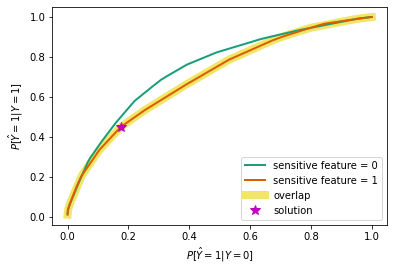

In [10]:
# print solution
print(to.interpolated_thresholder_)

# plot solution
plot_threshold_optimizer(to)

For African-American defendants the decision threshold is randomized between approximately 0.59 ($p=0.69$) and 0.54 ($p=0.31$). For Caucasian defendants the `ThresholdOptimizer` randomizes between a decision threshold of 0.46 ($p=0.992$) and 0.43 ($p=0.008$).

## Constrained Learning using `ExponentiatedGradient`

We can also directly take into account the fairness constraint during model training. One such approach is introduced by [Agarwal et al. (2018)](https://proceedings.mlr.press/v80/agarwal18a.html) which is implemented in Fairlearn's `fairlearn.reductions.ExponentiatedGradient`.


> #### A Reductions Approach to Fairness
> We can think about a reductions approach as a 'wrapper' around a machine learning algorithm (or `estimator` in scikit-learn terminology). The intuition behind the reductions approach in `ExponentiatedGradient` is to learn an ensemble of cost-sensitive classifiers, where each learned classifier is represents a different trade-off between the classification error and a fairness constraint. Each of these trade-offs is achieved by reweighing the training data set. At deployment time, `ExponentiatedGradient` randomizes between the classifiers in the ensemble, i.e., it selects one of the classifiers according to a set of predefined probability weights. This randomization scheme is selected such that the classification error is minimized under the fairness constraint. The name `ExponentiatedGradient` refers to the optimization approach that is used to solve this optimization problem: exponentiated gradient descent.
>
> Using this algorithm has the following implications
> * As opposed to `ThresholdOptimizer`, `ExponentiatedGradient` does not require access to sensitive features at training time.
> * Similar to `ThresholdOptimizer`, `ExponentiatedGradient` uses randomization, meaning that two individuals with the exact same characteristics can receive a different prediction.
> * By learning an ensemble of classifiers, we sacrifice interpretability of the underlying estimator.

The `ExponentiatedGradient` class has the following parameters:
* `estimator`: a (scikit-learn) estimator with a `fit(X, y, sample_weight)` and `predict(X)` method.
* `constraints` : the fairness constraints expressed as `Moment`s
* `eps` : allowed fairness constraint violation; the solution is guaranteed to have the error within 2*best_gap of the best error under constraint eps; the constraint violation is at most 2*(eps+best_gap).
* `max_iter`: Maximum number of iterations
* `nu` : convergence threshold
* `eta_0` : initial setting of the learning rate
* `run_linprog_step` : if True each step of exponentiated gradient is followed by the saddle point optimization over the convex hull of classifiers returned so far; default True
* `sample_weight_name` : name of the argument to estimator.fit() which supplies the sample weights (defaults to `'sample_weight'`)


And the familiar methods:
* `fit(X, y, sensitive_features)`
* `predict(X, random_state=None)`

To use the `ExponentiatedGradient` we need to define the constraint in the form of a `Moment`. In the case of equalized odds, this can be achieved using the `fairlearn.metrics.EqualizedOdds` moment.

### *Exercise*: train `ExponentiatedGradient` on the training data with a `LogisticRegression` model

In [11]:
# train model
eg = ExponentiatedGradient(
    estimator=LogisticRegression(), constraints=EqualizedOdds(), eps=0.01
)
eg.fit(X=X_train, y=y_train, sensitive_features=X_train["race_Caucasian"])

# score
score(
    y_train,
    eg.predict(X_train, random_state=0),
    y_test,
    eg.predict(X_test, random_state=0),
    X_train["race_Caucasian"],
    X_test["race_Caucasian"],
)

accuracy                 fpr                 fnr          
                   train      test     train      test     train      test
race_Caucasian                                                            
0               0.647352  0.640787  0.333654  0.333333  0.369547  0.384146
1               0.638384  0.644013  0.353201      0.32  0.374784  0.411523

equalized odds (test): 0.03
accuracy (test): 0.64


## Concluding Remarks
In this tutorial we have showcased several ways in which we can use fairness-aware machine learning algorithms to post-process or learn classifiers that adhere to a fairness constraint. In particular, we considered:
* post-processing predictions through manually identifying a group-specific decision threshold
* post-processing predictions through automatically identifying the optimal randomized group-specific decision thresholds using `ThresholdOptimizer`
* taking into account a fairness constraint during model training using `ExponentiatedGradient`

### Discussion Points
Here are several discussion points I would like to invite you to think about.

#### Connection to fairness metrics
* Fairness-aware pre-processing algorithms typically optimize for demographic parity, not for equalized odds or equal calibration. Can you explain why?
* How does post-processing for equalized odds affects other notions of fairness, such as equal calibration and demographic parity? As an exercise, compute fairness metrics that represent alternative notions of (group) fairness. Can you explain the results?

#### The justification of fair-ml
* Our manual choice of the decision threshold uses a different decision threshold for African-Americans than for Caucasians. Under which circumstances would you deem such a policy fair, if any? Why?
* The post-processing algorithm implemented in `ThresholdOptimizer` uses randomization in order to achieve equalized odds. Consequently, individuals with the exact same characteristics may receive a different prediction. Under which circumstances would you deem such a policy fair, if any? Why? *For the interested reader, I have tried to answer this question in [this paper](https://arxiv.org/abs/2202.08536).*
* The constrained learning algorithm implemented in `ExponentiatedGradient` trains an ensemble of classifiers. This vastly decreases the interpretabiltiy of the final model compared to plain logistic regression. Under which circumstances would you be willing to sacrifice interpretability for fairness, if at all? Why? *If you want to think more about the relationship between fairness interpretability you may find [this paper](https://hdsr.mitpress.mit.edu/pub/7z10o269/release/4) an interesting read*.

#### Beyond fair-ml
* In this tutorial, we have focussed on technical approaches to optimize for equalized odds. Can you think of other actions in the machine learning development process that could be used to enhance the predictive performance across groups, e.g., during problem formulation and data collection?
* In the United States, pretrial risk assessment tools are not used for automated decision-making. Instead, they are used as decision support for judges. Does this influence the way in which you would evaluate the fairness of a model in practice? Why (not)?